In [2]:
import warnings
warnings.filterwarnings("ignore")

import io
import os
import os.path
import re
import spacy
import time
import pickle

import numpy as np
import pandas as pd
from pprint import pprint

import gensim
from gensim.models import Phrases, LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.test.utils import datapath

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
os.environ.update({'MALLET_HOME':r'C:/mallet/mallet-2.0.8/'})
mallet_path = 'C:\\mallet\\mallet-2.0.8\\bin\\mallet'
pd.options.display.max_columns = 100

C:\Users\f.braulio\Anaconda3\envs\ugpn-covid-emotions\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\f.braulio\Anaconda3\envs\ugpn-covid-emotions\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

In [3]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def compute_coherence_values(id2word, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    for num_topics in range(start, limit, step):
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word, random_seed=50)
        model_list.append(ldamallet)
        coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_ldamallet.get_coherence())

    return model_list, coherence_values

def loop_compute_coherence_values(id2word, corpus, texts, limit, mallet_path, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=50)
        model_list.append(ldamallet)
        coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_ldamallet.get_coherence())
        print(num_topics)
    return model_list, coherence_values

# Load and process News Tweets

In [4]:
# Load lookup tables
media_list = pd.read_csv('./../data/external/MediaList.csv', sep=";")
news_accounts = pd.read_parquet('./../data/processed/news_accounts.parquet')
emotions = ['anger', 'sadness', 'optimism', 'joy']

# Process lookup tables
news_accounts = news_accounts.merge(media_list)
news_accounts['userId'] = news_accounts.userId.astype('float64')

# Load news tweets
news_tweets = pd.read_parquet('./../data/processed/consolidated/consolidated_news_tweets.parquet')

# Include country information and filter valid news accountsw
news_tweets = news_tweets.merge(news_accounts[['userId','country']])
news_tweets = news_tweets.sort_values('date').drop_duplicates('conversationId', keep='first')
news_tweets = news_tweets[news_tweets.lang=='en']
print('Number of valid news tweets:', news_tweets.shape[0])

# Generate content file
news_tweets = news_tweets.reset_index(drop=True)
data = list(news_tweets.content)
print("Just collected", len(data), "tweets.")
del media_list, news_accounts

Number of valid news tweets: 1719871
Just collected 1719871 tweets.


In [5]:
# Clean data
start = time.time()
nlp = spacy.load("en_core_web_sm")
docs = []
for doc in nlp.pipe(data, disable=["tok2vec", "tagger", "parser", "attribute_ruler"]):
    docs.append([
        re.sub(r'[^\w\s]|[0-9]|[_]', '', token.lemma_.lower()) for token in doc
        if not token.like_url
        and not token.is_punct
        and not token.is_stop
        and not token.is_space
        and not token.like_num
        and not token.ent_type_ == 'GPE'
        and not token.text.startswith('@')
        and len(token.text)>1
    ])
print("Finish 1", time.time() - start)

# Form Bigrams and Trigrams
start = time.time()
bigram = gensim.models.Phrases(docs, min_count=5, ) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[docs])
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
docs = make_bigrams(docs)
docs = make_trigrams(docs)
print("Finish 2", time.time() - start)

# Create a dictionary representation of the documents.
start = time.time()
dictionary = Dictionary(docs)
print("Finish 3", time.time() - start)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
start = time.time()
dictionary.filter_extremes(no_below=len(docs)*0.0005, no_above=0.33)
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token
print("Finish 4", time.time() - start)

# Bag-of-words representation of the documents.
start = time.time()
corpus = [dictionary.doc2bow(doc) for doc in docs]
print("Finish 5", time.time() - start)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Finish 1 2278.4770452976227
Finish 2 431.08384132385254
Finish 3 31.26934790611267
Finish 4 0.3418409824371338
Finish 5 14.406043291091919
Number of unique tokens: 1966
Number of documents: 1719871


In [2]:
0.0005 * 1719871

859.9355

# Coherence over number of topics

2
5
8
11
14
17
20
23
26
29
32
35
38


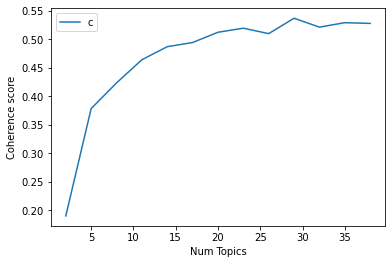

In [87]:
# Can take a long time to run.
limit=40; start=2; step=3;
model_list, coherence_values = loop_compute_coherence_values(id2word=id2word, corpus=corpus, texts=docs, mallet_path=mallet_path, start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [88]:
coherence_values

[0.1904751007100423,
 0.37879459862606674,
 0.42374450561744703,
 0.4644860060338329,
 0.487347851713527,
 0.4946509603327943,
 0.5126522710767392,
 0.5197612616471091,
 0.5102378284271195,
 0.5372328881105903,
 0.5216428422006523,
 0.5294609204296856,
 0.5281553643090436]

# Train LDA

In [6]:
# Train model
temp_file = datapath("model_0112")
ldamallet = gensim.models.wrappers.LdaMallet.load(temp_file)
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word, random_seed=50)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [90]:
# Save the model
# temp_file = datapath("model_0112")
# ldamallet.save(temp_file)

In [91]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16    -0.396016  0.158671       1        1  5.060770
1     -0.009428 -0.128291       2        1  5.039623
2      0.003147 -0.017628       3        1  5.024506
13     0.174889  0.241040       4        1  5.024422
9     -0.403878  0.159875       5        1  5.019313
12     0.079011  0.109183       6        1  5.016137
18     0.046577 -0.107687       7        1  5.014240
7      0.190188  0.237556       8        1  5.008797
4     -0.064104 -0.032795       9        1  5.005229
0      0.016744 -0.054228      10        1  5.001546
10     0.034346 -0.171774      11        1  5.000514
5      0.131533  0.125376      12        1  4.993291
17    -0.038118 -0.086385      13        1  4.992449
15     0.048746 -0.135952      14        1  4.989666
14    -0.026598 -0.075368      15        1  4.978413
19     0.155393  0.201998      16        1  4.976855
11    -0.006415 -0.098898      17        1  4.972301
3      0.019406 -0.107652      18        1  4.965963
6      0.028080 -0.129874      19        1  4.961092
8      0.016496 -0.087169      20        1  4.954872, topic_info=              Term           Freq          Total Category  logprob  loglift
102           case  258530.000000  258530.000000  Default  30.0000  30.0000
3         lockdown  194610.000000  194610.000000  Default  29.0000  29.0000
16         vaccine  177010.000000  177010.000000  Default  28.0000  28.0000
199       pandemic  239851.000000  239851.000000  Default  27.0000  27.0000
28          report  110141.000000  110141.000000  Default  26.0000  26.0000
..             ...            ...            ...      ...      ...      ...
681  test_positive   20849.085951   56030.431994  Topic20  -3.1904   2.0162
510           body    3615.240026    4292.322330  Topic20  -4.9425   2.8331
976          staff    5864.795545   13888.684292  Topic20  -4.4587   2.1427
340         infect    4456.501682   18077.789708  Topic20  -4.7333   1.6045
144          video    3360.676434   10493.352143  Topic20  -5.0155   1.8662

[1145 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
421       4  0.006357        access
421       8  0.048229        access
421      10  0.945285        access
444       3  0.000064        accord
444       9  0.419756        accord
...     ...       ...           ...
606      20  1.000051  year_old_man
657      19  0.000301         young
657      20  0.999640         young
1744      6  0.990879         youth
1744     11  0.009122         youth

[1911 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 2, 3, 14, 10, 13, 19, 8, 5, 1, 11, 6, 18, 16, 15, 20, 12, 4, 7, 9])

### Selected model coherence

In [115]:
m_coherence = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
m_coherence_general = m_coherence.get_coherence()
m_coherence_per_topic = m_coherence.get_coherence_per_topic()

In [116]:
pd.Series(np.round(np.array(m_coherence_per_topic) * 100,2))

0     61.93
1     45.41
2     51.05
3     49.47
4     49.34
5     50.58
6     37.59
7     50.76
8     52.80
9     64.86
10    51.59
11    51.03
12    50.64
13    55.25
14    38.98
15    48.63
16    72.33
17    52.99
18    42.98
19    47.09
dtype: float64

In [117]:
m_coherence_general

0.5126522710767392

### Topics prevalence

In [8]:
df_iter = ldamallet.load_document_topics()
df = []
for k in df_iter:
    df.append([i[1] for i in k])
df = pd.DataFrame(df, columns=[fr'topic_{k}' for k in range(20)])
df['topic'] = df.idxmax(axis=1)
df['num_topic'] = df.topic.apply(lambda x: int(x.replace('topic_','')))
df['tweetId'] = news_tweets.tweetId.values
df.to_parquet('./../data/processed/news_tweets_topics_0612.parquet')
df.num_topic.value_counts(normalize=True).sort_index() * 100

0     10.498346
1      7.302873
2      6.714864
3      8.019671
4      6.006439
5      6.530257
6      5.531054
7      5.162073
8      5.891895
9      5.644435
10     3.979252
11     4.660175
12     3.288677
13     3.843312
14     2.823177
15     2.860563
16     3.677660
17     2.723518
18     2.092657
19     2.749102
Name: num_topic, dtype: float64

### Topics keywords

In [93]:
pprint(model.print_topics())

[(0,
  '0.346*"vaccine" + 0.033*"dose" + 0.033*"receive" + 0.021*"astrazeneca" + '
  '0.020*"give" + 0.019*"trial" + 0.018*"supply" + 0.015*"ready" + 0.015*"jab" '
  '+ 0.014*"shoot"'),
 (1,
  '0.114*"government" + 0.076*"country" + 0.068*"read" + 0.042*"disease" + '
  '0.038*"national" + 0.022*"announce" + 0.022*"area" + 0.021*"list" + '
  '0.020*"official" + 0.020*"include"'),
 (2,
  '0.062*"week" + 0.053*"start" + 0.053*"month" + 0.047*"plan" + 0.047*"begin" '
  '+ 0.043*"end" + 0.039*"set" + 0.039*"announce" + 0.038*"march" + '
  '0.034*"early"'),
 (3,
  '0.099*"quarantine" + 0.069*"test_positive" + 0.060*"home" + 0.040*"day" + '
  '0.036*"travel" + 0.028*"return" + 0.027*"leave" + 0.017*"send" + '
  '0.013*"stay" + 0.012*"passenger"'),
 (4,
  '0.080*"day" + 0.054*"surge" + 0.044*"continue" + 0.041*"high" + '
  '0.040*"country" + 0.036*"hit" + 0.035*"week" + 0.033*"infection" + '
  '0.033*"wave" + 0.024*"datum"'),
 (5,
  '0.048*"response" + 0.043*"pandemic" + 0.035*"trump" + 0.033*

In [7]:
df_words = pd.DataFrame([])
topic_words = pd.DataFrame(columns=['topic', 'words'])
for topic in range(20):
    tmp = pd.DataFrame(model.get_topic_terms(topic,35), columns=['wordid','imp'])
    tmp['topic'] = topic
    tmp['word'] = tmp.wordid.apply(lambda x: dictionary[x])
    df_words = pd.concat([df_words, tmp])
    topic_words.loc[len(topic_words)] = [topic, (list(tmp.word.values))]
(topic_words.words.values)

array([list(['vaccine', 'dose', 'receive', 'astrazeneca', 'give', 'trial', 'supply', 'ready', 'jab', 'shoot', 'approve', 'pfizer', 'roll', 'develope', 'effective', 'eu', 'vaccinate', 'development', 'deliver', 'race', 'access', 'hope', 'shot', 'distribution', 'delivery', 'drug', 'administer', 'covidvaccine', 'volunteer', 'age', 'potential', 'shortage', 'approval', 'produce', 'johnson_amp_johnson']),
       list(['government', 'country', 'read', 'disease', 'national', 'announce', 'area', 'list', 'official', 'include', 'wednesday', 'thursday', 'add', 'tuesday', 'friday', 'affect', 'release', 'filipino', 'measure', 'decision', 'agency', 'remain', 'monday', 'suspend', 'continue', 'place', 'implement', 'operation', 'icymi', 'statement', 'ph', 'department', 'president_rodrigo_duterte', 'metro_manila', 'region']),
       list(['week', 'start', 'month', 'plan', 'begin', 'end', 'set', 'announce', 'march', 'early', 'expect', 'april', 'monday', 'year', 'reopen', 'june', 'day', 'need_know', 'july',

### Themes

In [9]:
topic2theme = pd.DataFrame({
    'topic':[fr'topic_{k}' for k in range(20)], 
    'theme':[8,5,6,6,1,5,7,2,4,1,6,6,5,2,5,7,1,5,2,3]
})
df = df.merge(topic2theme, how='left')

In [10]:
themes_keywords = []
for theme_id in range(1,9):
    theme = [int(t.replace('topic_', '')) for t in list(topic2theme[topic2theme.theme==theme_id].topic.values)]
    theme_words_tmp = pd.DataFrame()
    for topic in theme:
        tmp = pd.DataFrame(model.get_topic_terms(topic,40), columns=['wordid','imp'])
        theme_words_tmp = pd.concat([theme_words_tmp, tmp])
    theme_words_tmp = theme_words_tmp.sort_values('imp', ascending=False)
    theme_words_tmp['wordid'] = theme_words_tmp.wordid.apply(lambda x: dictionary[x])
    themes_keywords = themes_keywords + [list(theme_words_tmp.drop_duplicates('wordid').wordid.values[:40])]

In [11]:
ch2 = CoherenceModel(topics=themes_keywords, texts=docs, dictionary=dictionary, coherence='c_v')

In [12]:
cm = ch2.get_coherence()
ct = ch2.get_coherence_per_topic()

In [13]:
ct

[0.5499119210910914,
 0.36634718029460184,
 0.4491761580866596,
 0.5079310150786362,
 0.29246823267060074,
 0.3267263983445418,
 0.34401554600341194,
 0.6038524465903001]

In [14]:
cm

0.4300536122699805

In [15]:
df.theme.value_counts(normalize=True)

6    0.233740
5    0.226685
1    0.153285
2    0.110980
8    0.104983
7    0.083916
4    0.058919
3    0.027491
Name: theme, dtype: float64

In [19]:
theme_id = 8
theme = [int(t.replace('topic_', '')) for t in list(topic2theme[topic2theme.theme==theme_id].topic.values)]
np.array(list(dict.fromkeys(df_words[df_words.topic.isin(theme)].word.values)))

array(['vaccine', 'dose', 'receive', 'astrazeneca', 'give', 'trial',
       'supply', 'ready', 'jab', 'shoot', 'approve', 'pfizer', 'roll',
       'develope', 'effective', 'eu', 'vaccinate', 'development',
       'deliver', 'race', 'access', 'hope', 'shot', 'distribution',
       'delivery', 'drug', 'administer', 'covidvaccine', 'volunteer',
       'age', 'potential', 'shortage', 'approval', 'produce',
       'johnson_amp_johnson'], dtype='<U19')

### Subthemes

In [16]:
subthemes = [
    (1,11,['rise', 'increase', 'high', 'spike', 'jump', 'reach', 'double', 'climb', 'soar', 'record_high', 'death_toll_rise', 'peak', 'hit', 'high_daily', 'top', 'exceed', 'high_single_day', 'tally_rise']),
    (1,12,['low', 'drop', 'fall', 'dip', 'decrease']),
    (2,21,['worker', 'plan', 'work', 'support', 'free', 'job', 'employee', 'food', 'citizen', 'congress', 'poor', 'protect', 'people', 'vulnerable', 'household', 'essential', 'loan', 'small_business', 'lose_job', 'donation', 'employer', 'assistance', 'job_loss']),
    (2,22,['impact', 'business', 'government', 'economy', 'global', 'demand', 'market', 'company', 'industry', 'cut', 'aid', 'budget', 'sector', 'boost', 'bank', 'bill', 'stock', 'quarter', 'trade', 'law', 'growth', 'lawmaker', 'office', 'relief_bill', 'supreme_court', 'economic_recovery', 'debt', 'profit', 'relief_package', 'global_economy', 'stimulus_package', 'world_bank', 'relief_fund', 'organisation']),
    (4,41,['nurse_home', 'care_home']),
    (4,42,['mental_health']),
    (4,43,['jail', 'prison', 'cop', 'inmate']),
    (4,44,['family', 'couple', 'wife', 'mother', 'son', 'daughter', 'husband', 'father', 'mum', 'baby', 'dad']),
    (5,51,['health_official', 'health_minister', 'expert', 'task_force', 'public_health', 'dr_anthony_fauci', 'chief_medical_officer']),
    (5,52,['trump', 'pm', 'president', 'president_trump', 'minister', 'white_house', 'leader', 'pm_modi', 'governor', 'govt', 'president_donald_trump', 'donald_trump', 'administration', 'federal', 'biden', 'mp', 'joe_biden', 'trudeau', 'trump_administration', 'pm_narendra_modi', 'leadership', 'pres_trump', 'prime_minister_justin_trudeau', 'opposition', 'government']),
    (5,53,['election', 'poll', 'debate', 'voter']),
    (6,61,['lockdown', 'restriction', 'quarantine', 'police', 'rule', 'impose', 'protocol', 'quarantine_facility', 'mandatory', 'community_quarantine', 'stay_home_order', 'containment_zone', 'covidquarantine', 'quarantine_period']),
    (6,62,['travel', 'passenger', 'flight', 'airport', 'plan', 'airline', 'tourism', 'fly', 'traveller', 'travel_ban', 'trip', 'vaccine_passport']),
    (6,63,['protest', 'anti', 'break', 'arrest', 'fine', 'protester']),
    (6,64,['social_distance', 'mask', 'wear_mask', 'social_distance_measure']),
    (6,65,['christmas', 'holiday', 'easter']),
    (6,66,['ease', 'relax', 'restriction_ease', 'ease_restriction', 'slow_spread']),
    (7,71,['outbreak', 'fear', 'chinese', 'detect', 'epidemic', 'suspect', 'emerge', 'panic', 'epicentre', 'animal', 'origin', 'china', 'epicenter']),
    (7,72,['hospital', 'study', 'treatment', 'research', 'lab', 'expert', 'cure', 'researcher', 'scientist', 'ventilator', 'study_find', 'medicine', 'scientists', 'private_hospital', 'expert_warn', 'oxygen', 'researchers', 'intensive_care', 'study_show', 'hospitals', 'palliative']),
    (7,73,['variant', 'wave', 'strain', 'mutation']),
    (7,74,['doctor', 'medical', 'healthcare_worker', 'health_worker', 'doctors', 'health_care_worker'])
]

In [17]:
for col in [fr'subtheme{subtheme[1]}' for subtheme in subthemes]:
    df[col] = False

In [18]:
for k in range(1,9):
    subthemes_desc = [subtheme for subtheme in subthemes if subtheme[0]==k]
    if len(subthemes_desc)>0:
        indices = list(df[df.theme==k].index)
        topic_docs = [docs[i] for i in indices]
        for subtheme_desc in subthemes_desc:
            kw = subtheme_desc[2]
            t = [ind for k, ind in enumerate(indices) if any(i in topic_docs[k] for i in kw)]
            df.loc[t,fr'subtheme{subtheme_desc[1]}'] = True

In [19]:
df[[fr'subtheme{subtheme[1]}' for subtheme in subthemes]].sum()

subtheme11     75511
subtheme12     14259
subtheme21     42662
subtheme22     51198
subtheme41      2214
subtheme42        75
subtheme43       982
subtheme44     14107
subtheme51     12735
subtheme52     96187
subtheme53      6999
subtheme61    148678
subtheme62     37233
subtheme63     14535
subtheme64     13296
subtheme65      6523
subtheme66     12707
subtheme71     32926
subtheme72     23564
subtheme73      8348
subtheme74      3084
dtype: int64

In [20]:
df.to_parquet('./../data/processed/news_tweets_topics_0612.parquet', compression='gzip', index=False)

In [25]:
df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic,num_topic,tweetId,theme,subtheme11,subtheme12,subtheme21,subtheme22,subtheme41,subtheme42,subtheme43,subtheme44,subtheme51,subtheme52,subtheme53,subtheme61,subtheme62,subtheme63,subtheme64,subtheme65,subtheme66,subtheme71,subtheme72,subtheme73,subtheme74
0,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.086538,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,topic_6,6,1212176883305111554,7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,0.044643,0.044643,0.062500,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.062500,0.044643,0.044643,0.062500,0.044643,0.044643,0.044643,0.098214,0.044643,topic_18,18,1212187503463223296,2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0.047170,0.047170,0.047170,0.047170,0.047170,0.047170,0.066038,0.047170,0.047170,0.047170,0.047170,0.047170,0.047170,0.047170,0.047170,0.066038,0.047170,0.047170,0.047170,0.066038,topic_6,6,1212193136816148480,7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,0.062500,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.080357,0.044643,0.098214,0.044643,0.044643,0.044643,0.044643,topic_15,15,1212478036119040001,7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
4,0.081818,0.045455,0.063636,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.063636,0.045455,0.063636,0.045455,0.045455,topic_0,0,1212520131315818496,8,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719866,0.041667,0.058333,0.041667,0.058333,0.041667,0.058333,0.041667,0.041667,0.041667,0.041667,0.041667,0.058333,0.058333,0.041667,0.041667,0.058333,0.058333,0.091667,0.041667,0.041667,topic_17,17,1387918189342822405,5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1719867,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.101852,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,topic_9,9,1387918271446323200,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1719868,0.043103,0.043103,0.060345,0.043103,0.077586,0.043103,0.043103,0.043103,0.043103,0.043103,0.043103,0.043103,0.060345,0.077586,0.043103,0.043103,0.043103,0.043103,0.043103,0.077586,topic_4,4,1387918637030264834,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1719869,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.064815,topic_4,4,1387919253827903496,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# Trunk

In [39]:
vis.sorted_terms(1, 0.64).Term.values

array(['case', 'report', 'death', 'confirm', 'total', 'hour', 'recovery',
       'record', 'breaking', 'death_toll', 'fresh', 'active_case',
       'fatality', 'stand', 'additional', 'total_numb', 'tally',
       'health_ministry', 'department_health', 'discharge', 'covidph',
       'health_department', 'today', 'death_toll_rise', 'doh',
       'past_hour', 'bring_total', 'reach', 'relate_death',
       'ministry_health', 'patient_recover', 'bring_total_numb',
       'union_health_ministry', 'additional_death', 'take_total_numb',
       'include', 'total_active', 'sample_test', 'tally_rise', 'dfa',
       'patient_discharge', 'manage_isolation'], dtype=object)

In [122]:
model.get_term_topics(1)

[(6, 0.08518786635782674), (15, 0.02161607494103565)]

In [183]:
list(dictionary.values)

TypeError: 'method' object is not iterable

In [166]:
with open("data_pp.pickle", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

In [188]:
themes_keywords2 = []
for theme in themes:
    theme_words_tmp = pd.DataFrame()
    for topic in theme:
        tmp = pd.DataFrame(model.get_topic_terms(topic,50), columns=['wordid','imp'])
        theme_words_tmp = pd.concat([theme_words_tmp, tmp])
    theme_words_tmp = theme_words_tmp.sort_values('imp', ascending=False)
    theme_words_tmp['wordid'] = theme_words_tmp.wordid.apply(lambda x: d[x])
    themes_keywords2 = themes_keywords2 + [list(theme_words_tmp.drop_duplicates('wordid').wordid.values[:50])]

In [195]:
themes_keywords2[3]

['test_positive',
 'patient',
 'hospital',
 'die',
 'people',
 'doctor',
 'staff',
 'person',
 'contract',
 'treatment',
 'recover',
 'treat',
 'year_old',
 'battle',
 'facility',
 'care',
 'symptom',
 'medical',
 'infect',
 'nurse',
 'test_negative',
 'man',
 'suspect',
 'health_worker',
 'victim',
 'dr',
 'admit',
 'body',
 'dead',
 'contact',
 'nurse_home',
 'diagnose',
 'fire',
 'wife',
 'condition',
 'young',
 'bed',
 'attend',
 'recently',
 'ventilator',
 'doctors',
 'age',
 'healthcare_worker',
 'nhs',
 'prison',
 'self_isolate',
 'sick',
 'shift',
 'self_quarantine',
 'isolation']

In [54]:
df_iter = ldamallet.load_document_topics()
df = []
for k in df_iter:
    df.append([i[1] for i in k])
df = pd.DataFrame(df, columns=[fr'topic_{k}' for k in range(20)])

In [56]:
df['topic'] = df.idxmax(axis=1)
df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic
0,0.041667,0.041667,0.058333,0.058333,0.058333,0.041667,0.041667,0.058333,0.058333,0.058333,0.041667,0.041667,0.058333,0.075000,0.041667,0.058333,0.041667,0.041667,0.041667,0.041667,topic_13
1,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.083333,0.046296,0.064815,0.046296,0.046296,0.046296,topic_14
2,0.044643,0.080357,0.044643,0.044643,0.044643,0.044643,0.044643,0.062500,0.044643,0.044643,0.044643,0.044643,0.080357,0.044643,0.044643,0.044643,0.062500,0.044643,0.044643,0.044643,topic_1
3,0.101562,0.070312,0.039062,0.039062,0.039062,0.039062,0.054688,0.039062,0.132812,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.054688,0.039062,0.039062,topic_8
4,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,topic_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814501,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.067308,0.048077,0.048077,0.048077,0.048077,0.067308,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,topic_8
1814502,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.120370,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,topic_11
1814503,0.044643,0.044643,0.080357,0.044643,0.062500,0.044643,0.062500,0.062500,0.044643,0.062500,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,topic_2
1814504,0.046296,0.046296,0.046296,0.046296,0.083333,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.064815,topic_4


In [87]:
df_iter = ldamallet.load_document_topics()
df = []
for k in df_iter:
    df.append([i[1] for i in k])
df = pd.DataFrame(df, columns=[fr'topic_{k}' for k in range(20)])
df['topic'] = df.idxmax(axis=1)

In [62]:
topic2theme = pd.DataFrame({
    'topic':[fr'topic_{k}' for k in range(20)], 
    'theme':[7,3,2,1,2,1,2,5,7,6,6,6,5,7,5,8,1,4,4,6]
})

df = df.merge(topic2theme, how='left')

In [65]:
for col in [fr'subtheme{subtheme[1]}' for subtheme in subthemes]:
    df[col] = False

In [68]:
for k in range(1,9):
    subthemes_desc = [subtheme for subtheme in subthemes if subtheme[0]==k]
    if len(subthemes_desc)>0:
        indices = list(df[df.theme==k].index)
        topic_docs = [b[0][i] for i in indices]
        for subtheme_desc in subthemes_desc:
            kw = subtheme_desc[2]
            t = [ind for k, ind in enumerate(indices) if any(i in topic_docs[k] for i in kw)]
            df.loc[t,fr'subtheme{subtheme_desc[1]}'] = True

In [70]:
tweets.tweetId.values

array([1331811812828803073, 1237432142214258688, 1234744569268338689, ...,
       1310723512223625216, 1266240991133970438, 1325600258848600065],
      dtype=int64)

In [71]:
df['tweetId'] = tweets.tweetId.values

In [73]:
df[[fr'topic_{k}' for k in range(20)]].max(axis=1).max()

0.2681159420289854

In [186]:
df.shape[0]

1814506

In [165]:
tweets[tweets.tweetId.isin(df[df.subtheme73].tweetId.values)].sample(25).content.values

array(['Some of Melbourne’s biggest hospitals are bracing themselves for a huge surge of COVID-19 cases in coming days. \n\nThis is how the second wave crisis has unfolded in hospitals. https://t.co/aeSah0MkPV',
       'What we know about COVID vaccine effectiveness against the new variants https://t.co/Su7gSgMVQw',
       'Second waves of the pandemic have occurred around the world, sparking fears that Australia could be next. But experts say it’s avoidable.\n\nhttps://t.co/xz27TIOakS',
       "Japan detects new mutant 'vaccine-busting' Covid variant from traveller coming from Philippines https://t.co/1X8tTlXpQ5",
       'A leading medical professor claims lifting restrictions on air travel could cause a second wave of Covid-19 cases.\n\nhttps://t.co/dHTERBP8zf',
       'Wuhan to test all 11 million residents after the #COVID19 epicentre in China witnesses a second wave of coronavirus infection. @SinghBhairavi has more https://t.co/idQMokjJUL',
       'Health officials are calling on 

In [ ]:
# Train model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word, random_seed=50)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
temp_file = datapath("model")
ldamallet.save(temp_file)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
# Train model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

In [ ]:
pprint(model.print_topics())
doc_lda = model[corpus]

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
1

In [ ]:
ldamallet[corpus[10]]

In [ ]:
# Compute tweets topics
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=list(tweets.content))

# Format
df = df_topic_sents_keywords.reset_index()
df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df.to_csv('tweets_topics2.csv')

# Show
df.head(5)

In [ ]:
df = pd.read_csv('tweets_topics2.csv')

In [ ]:
df[df.Topic_Perc_Contrib==0.05]

In [ ]:
indices = list(df_dominant_topic[df_dominant_topic.Dominant_Topic==2.0].Document_No)
topic_docs = [docs[i] for i in indices]

kw = ['low', 'fall', 'drop', 'decline']
t = [ind for k, ind in enumerate(indices) if any(i in topic_docs[k] for i in kw)]
len(t)

In [ ]:
(df.Dominant_Topic.value_counts() / df.shape[0]).sort_index()

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(10)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.to_csv('relevant_topics2.csv', sep="|")

In [ ]:
sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Topic_Num==19.0].Text.values

In [ ]:
topic_desc = pd.read_csv('topic_desc.csv', sep=';')

In [ ]:
# required: tweets, df, docs
tweets['theme'] = np.nan
for topic in topic_desc.topic.unique():
    topic_themes = topic_desc[topic_desc.topic==topic]
    non_default = []
    for index, row in topic_themes[topic_themes.default=='F'].iterrows():
        kw = row.keywords.replace(' ', '').split(',')
        t = [k for k in df[df.Dominant_Topic==topic].Document_No.values if any(i in kw for i in docs[k])]
        tweets.loc[t, 'theme'] = row.theme_id
        non_default = non_default + t
    topic_tweets = [k for k in df[df.Dominant_Topic==topic].Document_No.values]
    topic_tweets = np.setdiff1d(topic_tweets,non_default)
    tweets.loc[topic_tweets, 'theme'] = topic_themes[topic_themes.default=='T'].theme_id.unique()[0]

In [ ]:
topic_themes.themes.unique()[0]

In [ ]:
topic = 11
topic_themes = topic_desc[topic_desc.topic==topic]
non_default = []

In [ ]:
topic_themes

In [ ]:
topic_desc

In [ ]:
topic = 10
topic_desc[topic_desc.topic==topic]

In [ ]:
topic = 1
topic_themes = topic_desc[topic_desc.topic==topic]
non_default = []
for index, row in topic_themes[topic_themes.default=='F'].iterrows():
    kw = row.keywords.replace(' ', '').split(',')
    t = [k for k in df[df.Dominant_Topic==topic].Document_No.values if any(i in kw for i in docs[k])]
    print(row.themes, len(t))

In [ ]:
topic = 1
for topic in topic_desc.topic.unique():
    topic_themes = topic_desc[topic_desc.topic==topic]
    non_default = []
    for index, row in topic_themes[topic_themes.default=='F'].iterrows():
        kw = row.keywords.replace(' ', '').split(',')
        t = [k for k in df[df.Dominant_Topic==topic].Document_No.values if any(i in kw for i in docs[k])]
        print(row.themes, len(t))

In [ ]:
tweets[tweets.theme=='Elections'].content[:10].values

In [ ]:
tweets[['tweetId', 'theme']].to_parquet('news_tweets_topics.parquet', compression='gzip', index=False)

In [ ]:
tweets.theme.value_counts() / tweets.shape[0]

In [ ]:
topic_desc.topic.unique()

In [ ]:
tweets.theme.isnull().sum()

In [ ]:
topic_desc.keywords[20]

In [ ]:
docs[92]

In [ ]:
tweets[tweets.theme=='People violating mobility restrictions or protesting against them'].sample(frac=1).head(10).content.values

In [ ]:
(tweets.theme.nunique())

In [ ]:
df[df.Dominant_Topic==3.0]